# How to organise machine learning experiments?


Thomas Boquet


github: [@tboquet](https://github.com/tboquet)

## Problems?

- Training **complex** machine learning **models** could take some **time** and **ressources**.

- It's **not efficient** for one researcher to run **several scripts sequentially** on a server.

- When you are in a team with **multiple researchers** using **multiple (GPU) servers** it becomes **a mess**.

- You also need to **save** the architecture, the parameters and more **infos** (data, dependencies, etc) about each **model**.

- The servers have to be configured (CUDA, Theano, etc.)

![image](http://images.techtimes.com/data/images/full/146106/macgyver-jpg.jpg)

It's **possible** to:

- **assign hardware** from the same machine or from **several servers** to an application (nvidia-docker)

- **save all the info** in a database

- retrieve the info, **rebuild the same models** and serve them in a **production pipeline**!

*(like TensorFlow Serving...)*

### Let's do this using a simple API!

# ALP

## How to use it?

(after the setup)

### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dense
from keras.layers import Input, Lambda
from keras.models import Model
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils.test_utils import get_test_data
import numpy as np

from alp.appcom.core import Experiment

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


### Fake data stuff

In [2]:
np.random.seed(1337)


input_dim = 2
nb_hidden = 4
nb_class = 10
batch_size = 128
train_samples = 40000
test_samples = 20

In [3]:
(X_tr, y_tr), (X_te, y_te) = get_test_data(nb_train=train_samples,
                                            nb_test=test_samples,
                                            input_shape=(input_dim,),
                                            classification=True,
                                            nb_class=nb_class)

y_tr = np_utils.to_categorical(y_tr)
y_te = np_utils.to_categorical(y_te)

data, data_val = dict(), dict()

data["X"] = X_tr
data["y"] = y_tr

data_val["X"] = X_te
data_val["y"] = y_te


metrics = ['accuracy']

### Model!

In [4]:
model = Sequential()
model.add(Dense(nb_hidden, input_dim=input_dim, activation='relu'))
model.add(Lambda(lambda x: x + x**2 + x**3))
model.add(Dense(nb_class, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

expe = Experiment(model)

### Simple fit

In [5]:
history_1 = expe.fit([data], [data_val], nb_epoch=40, batch_size=batch_size, verbose=0)

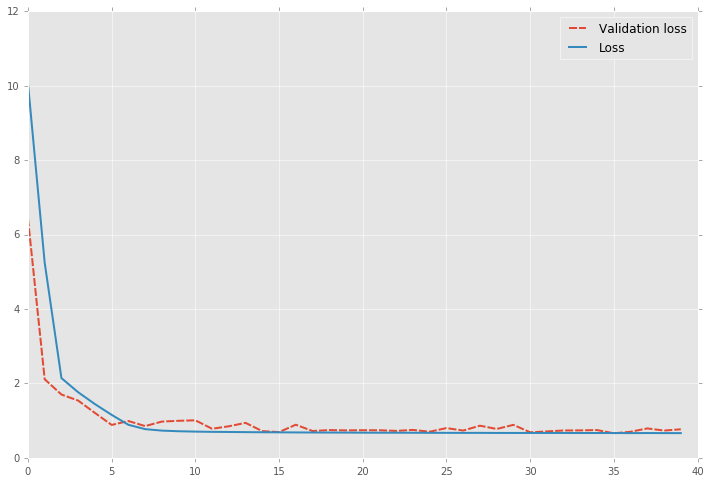

In [6]:
fig = plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.plot(history_1['metrics']["val_loss"], dashes=[8,2], linewidth=2, label="Validation loss")
plt.plot(history_1['metrics']["loss"], linewidth=2, label="Loss")
plt.legend()
plt.show()

### In async mode!

In [7]:
model = Sequential()
model.add(Dense(nb_hidden, input_dim=input_dim, activation='relu'))
model.add(Lambda(lambda x: x + x**2 + x**3))
model.add(Dense(nb_class, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

expe = Experiment(model)

expe.fit_async([data], [data_val],
               nb_epoch=40, batch_size=batch_size)

<AsyncResult: 1c9bd9f4-fa0d-42ca-afa5-5cb28c87bb87>

Result 82105cacb1cb127240e7b65487f6c7cf ready


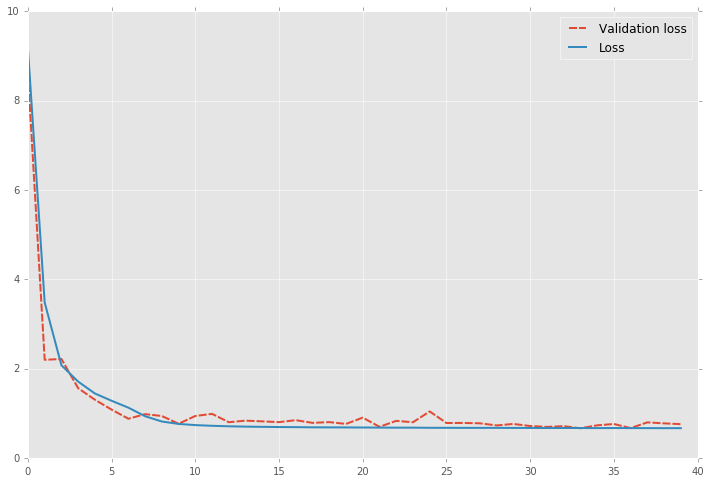

In [8]:
history_2 = expe.full_res
fig = plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.plot(history_2['metrics']["val_loss"], dashes=[8,2], linewidth=2, label="Validation loss")
plt.plot(history_2['metrics']["loss"], linewidth=2, label="Loss")
plt.legend()
plt.show()

### First look at the architecture

![arch](http://python-alp.readthedocs.io/en/latest/_images/architecture.svg)

## What happened?

![celery](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/celery.gif)

![task_celery](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/task_celery.png)

## Let's send a lot of models

In [11]:
expes = []
for i in range(20):
    model = Sequential()
    model.add(Dense(nb_hidden + i, input_dim=input_dim, activation='relu'))
    model.add(Lambda(lambda x: x + x**2 + x**3))
    model.add(Dense(nb_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    expe = Experiment(model)

    print(expe.fit_async([data], [data_val],
                         nb_epoch=40, batch_size=batch_size))
    expes.append(expe)

238d5f97-21b8-4ac5-a5a4-3eadbb52d89d
0fdf0dde-b0cd-465f-b0fd-a3f0f37fddf2
f1499e88-367d-4406-a1da-6e0e28879d18
8628e590-98b9-4fe5-880b-e0aefa2e3fcb
f4ac2406-9ba7-4f0f-80a2-21701dd2e2e2
f304475f-e041-44a9-ae66-10ddf3db9f4b
d50d2ce2-caaa-4ec2-b9bd-76f5de350058
8fd6dd2c-82ea-4f9f-9e65-75f14cae2086
c4531d30-b47a-495a-8f86-71cf78536c4a
cf8a63cd-fc04-463a-919a-a33f589d292c
037c89e4-d9d6-4312-ab46-6d7918d883c0
fbdfa3c9-78a6-4c21-b729-c843e6c44d40
092c0429-9e85-474b-bc77-9d52322e023e
e1905150-95b4-46c2-9530-5fb2aac1c16e
1598678c-de7b-413e-a792-f7fef53cf771
fdebe9a8-6dbf-4252-bca7-817e22f0fab6
b4f0dbac-1713-4610-b28b-b6ba8befceb4
48635f94-fdb3-4e10-a3f0-794abf517dc4
2d2c79ad-2fce-4b1b-ad7f-75eda390e44f
c9388886-6647-41ff-a1ba-e28efa0886b3
Result 5afa6f03684caf073612169e0cb80430 ready
Result 94a2539b13ae3f2b60383a23dce9ca45 ready
Result cf811f136285de90947dd36bbde8aae0 ready
Result 73ec6e3aa6f63e17b44fa1e389c73b15 ready
Result edb1bbf9d24261be1b0a42a2dae7dd2c ready
Result 2bfc22c866efc51339848b6

## We could take a look at Celery and RabbitMQ's admin panel

![queue_rabbit](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/queue_rabbit.png)

![queue](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/queue.gif)

## And the processes using the GPU(s)

![gpu_processes](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/gpu_processes.gif)

# Thank you!


**[Alp's doc](http://python-alp.readthedocs.io/en/latest/)**


**[Alp on github](https://github.com/tboquet/python-alp)**
